# **Clustering lynx**

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import random
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from scipy.stats import norm
from safetensors import safe_open

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from oml.functional.metrics import calc_cmc, calc_map, calc_precision
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

from lynx_id.data.dataset import LynxDataset
from lynx_id.data.transformations_and_augmentations import transforms
from lynx_id.data.collate import collate_single
from lynx_id.model.embeddings import EmbeddingModel
from lynx_id.model.clustering import ClusteringModel
from lynx_id.eval.eval import EvalMetrics
from lynx_id.utils.plot_results import plot_multiple_bar

plt.rcParams['figure.figsize'] = [20, 5]

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE=}")

DEVICE='cuda'


In [4]:
random.seed(42)

## **Prepare data**

### Load dataset

In [5]:
# load dataset
from lynx_id.data.dataset import LynxDataset
from pathlib import Path
from lynx_id.data.transformations_and_augmentations import transforms

lynxDataset = LynxDataset(dataset_csv=Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full.csv"), 
                      loader="pil",
                      transform=transforms,  # Define 'preprocess' earlier in your script
                      augmentation=None,
                      probabilities=[1, 0, 0],
                      mode='single',
                      device="auto")

In [6]:
print(f"{len(lynxDataset)}")

11830


In [7]:
train_lynxDataset, valid_lynxDataset, test_lynxDataset = lynxDataset.split()

In [8]:
print(f"{len(train_lynxDataset)=} images")
print(f"{len(valid_lynxDataset)=} images")
print(f"{len(test_lynxDataset)=} images")

len(train_lynxDataset)=9169 images
len(valid_lynxDataset)=1119 images
len(test_lynxDataset)=1542 images


In [9]:
train_lynx_id_counts = train_lynxDataset.dataframe['lynx_id'].value_counts()
test_lynx_id_counts = test_lynxDataset.dataframe['lynx_id'].value_counts()


print(f"TRAIN | Number of individuals: {len(train_lynx_id_counts)}")
print(f"TEST  | Number of individuals: {len(test_lynx_id_counts)}")

TRAIN | Number of individuals: 688
TEST  | Number of individuals: 655


In [10]:
set_individuals_train = set(train_lynx_id_counts.index)
set_individuals_test = set(test_lynx_id_counts.index)

print(f"The train and test set share {len(set_individuals_train.intersection(set_individuals_test))} individuals in common.")
print(f"Compared to the training set, the test set has {len(set_individuals_test - set_individuals_train)} new individuals.")

The train and test set share 608 individuals in common.
Compared to the training set, the test set has 47 new individuals.


In [11]:
new_lynx_id = set_individuals_test - set_individuals_train

In [12]:
train_dataloader = DataLoader(
    train_lynxDataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

test_dataloader = DataLoader(
    test_lynxDataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

### Load our best model to get embeddings from image

In [13]:
import os

# Assuming $ALL_CCFRWORK is an environment variable that stores the desired path
hub_dir = '/gpfswork/rech/ads/commun/models'

if hub_dir is not None:
    torch.hub.set_dir(hub_dir)
else:
    print("Environment variable 'ALL_CCFRWORK' is not set.")

In [14]:
dinov2 = torch.hub.load(repo_or_dir='facebookresearch/dinov2', model='dinov2_vitl14_reg').to(DEVICE)

Using cache found in /gpfswork/rech/ads/commun/models/facebookresearch_dinov2_main
/gpfswork/rech/ads/commun/models/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/gpfswork/rech/ads/commun/models/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/gpfswork/rech/ads/commun/models/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


In [15]:
dinov2.eval()
train_embeddings=None

for i, batch in enumerate(tqdm(train_dataloader, total=len(train_dataloader))):
    batch_tensor = torch.stack(batch[0]['image']).to(DEVICE).float()

    with torch.no_grad():
        batch_embeddings = dinov2(batch_tensor)

        if train_embeddings is None:
            train_embeddings = batch_embeddings
        else:
            train_embeddings = torch.cat((train_embeddings, batch_embeddings), dim=0)

100%|██████████| 287/287 [03:26<00:00,  1.39it/s]


In [17]:
test_embeddings=None

for i, batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
    batch_tensor = torch.stack(batch[0]['image']).to(DEVICE).float()

    with torch.no_grad():
        batch_embeddings = dinov2(batch_tensor)

        if test_embeddings is None:
            test_embeddings = batch_embeddings
        else:
            test_embeddings = torch.cat((test_embeddings, batch_embeddings), dim=0)

100%|██████████| 49/49 [00:38<00:00,  1.29it/s]


In [18]:
train_embeddings = train_embeddings.to("cpu")
test_embeddings = test_embeddings.to("cpu")

print(f"TRAIN | Number of images: {train_embeddings.shape[0]} | Embedding shape: {train_embeddings.shape[1]}")
print(f"TEST  | Number of images: {test_embeddings.shape[0]} | Embedding shape: {test_embeddings.shape[1]}")

TRAIN | Number of images: 9169 | Embedding shape: 1024
TEST  | Number of images: 1542 | Embedding shape: 1024


In [19]:
# True lynx_id
test_lynx_id = test_lynxDataset.dataframe['lynx_id'].tolist()
train_lynx_id = train_lynxDataset.dataframe['lynx_id'].to_list()

# Update of true `lynx_id` data 
count_new = 0
for i, element in enumerate(tqdm(test_lynx_id)):
    if element in new_lynx_id:
        test_lynx_id[i] = "New"
        count_new += 1

print(f"{count_new=}")

100%|██████████| 1542/1542 [00:00<00:00, 2419609.71it/s]

count_new=47


In [20]:
# Check that we have new individuals
assert "New" in test_lynx_id

## **KNN**

In [21]:
clustering_model = ClusteringModel(
    embeddings_knowledge=train_embeddings,
    lynx_ids_knowledge=train_lynx_id,
    n_neighbors=5,
    algorithm="brute",
    metric="minkowski"
)

In [22]:
# Nearest Neighbors
clustering_model.clustering(test_embeddings)
indices = clustering_model.indices
distances = clustering_model.distances
indices.shape

(1542, 5)

### Detecting new candidates

In this notebook, we use both a **simple threshold** defined manually and a method **based on the Gaussian distribution of the clusters**.

### Compute metrics

#### CMC@k, mAP@k
We use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k** and **mAP@k**.

Before calculating the metrics, we need to **adapt `candidates_nearest_neighbors` to the detection of new individuals after our calculation with confidence intervals**. Candidate i, if detected as new, will have "New" as its nearest neighbour, then its neighbours calculated via KNN will be shifted by 1. The last one is therefore forgotten.  

Example:  
candidate i: `["A", "B", "C", "D"]` detected as New -> `["New", "A", "B", "C", "D"]`

In [23]:
top_k = (1, 2, 3, 4, 5)

eval_metrics = EvalMetrics(
    candidates_nearest_neighbors=clustering_model.candidates_nearest_neighbors,
    lynx_id_true=test_lynx_id,
    top_k=top_k
)

Computation of accuracy without detection of new candidates with 1-KNN.

In [24]:
accuracy_no_threshold = eval_metrics.compute_accuracy(lynx_id_predicted=clustering_model.one_knn())
print(f"Accuracy 1-KNN: {accuracy_no_threshold}")

Accuracy 1-KNN: 0.43320363164721143


#### Detection of new candidates with threshold

Searching for the best threshold

In [33]:
# thresholds = [0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.4, 1.6, 1.8, 2.0]
thresholds = [4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]


score_threshold = {'precision': [], 'recall': [], 'accuracy': []}

for threshold in thresholds:
    candidates_predicted_new_individual = clustering_model.check_new_individual(
        embeddings=test_embeddings,
        candidates_predicted=clustering_model.one_knn(),
        threshold=threshold,
    )
    
    precision_recall = eval_metrics.precision_recall_individual(
        candidates_predicted=candidates_predicted_new_individual, 
        individual_name="New",
        verbose=False
    )

    accuracy_threshold = eval_metrics.compute_accuracy(
        lynx_id_predicted=candidates_predicted_new_individual,
    )
    
    score_threshold['precision'].append(precision_recall['precision'])
    score_threshold['recall'].append(precision_recall['recall'])
    score_threshold['accuracy'].append(accuracy_threshold)

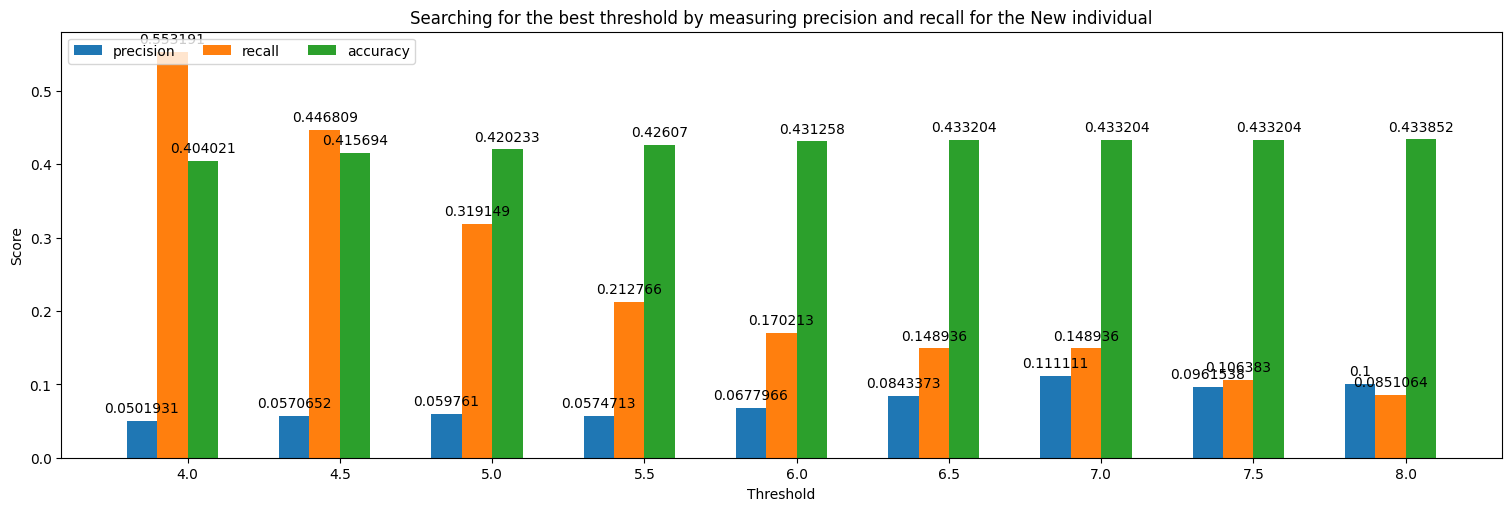

In [34]:
plot_multiple_bar(
    values=score_threshold,
    x_values=thresholds,
    xlabel="Threshold",
    ylabel="Score",
    title="Searching for the best threshold by measuring precision and recall for the New individual"
)

We choose a threshold based on the previous results for the following.

In [37]:
threshold = 6.5

cmc_values = {}
map_values = {}

In [38]:
### Threshold ###
print("-"*50, "New individual based on threshold", "-"*50)
candidates_predicted_new_individual = clustering_model.check_new_individual(
    embeddings=test_embeddings,
    candidates_predicted=clustering_model.one_knn(),
    threshold=threshold,
)

precision_recall = eval_metrics.precision_recall_individual(
    candidates_predicted=candidates_predicted_new_individual, 
    individual_name="New",
    verbose=True
)
print(precision_recall)

accuracy_threshold = eval_metrics.compute_accuracy(
    lynx_id_predicted=candidates_predicted_new_individual,
)
print(f"Accuracy 1-KNN threshold: {accuracy_threshold}")


# CMC@k + mAP@k
candidates_nearest_neighbors_new = clustering_model.compute_candidates_nearest_neighbors_new(
    candidates_predicted_new_individual=candidates_predicted_new_individual
)
eval_metrics.candidates_nearest_neighbors = candidates_nearest_neighbors_new
cmc_k_mean, map_k_mean = eval_metrics.compute_cmc_map_metrics()
print(f"{cmc_k_mean=}")
print(f"{map_k_mean=}")
cmc_values['threshold'] = list(cmc_k_mean.values())
map_values['threshold'] = list(map_k_mean.values())

-------------------------------------------------- New individual based on threshold --------------------------------------------------
New individual predicted 83 times (total number of images: 1542). In reality, the New individual appears 47 times.
{'precision': 0.08433734939759036, 'recall': 0.14893617021276595}
Accuracy 1-KNN threshold: 0.43320363164721143
cmc_k_mean={1: 0.433, 2: 0.495, 3: 0.528, 4: 0.551, 5: 0.564}
map_k_mean={1: 0.433, 2: 0.464, 3: 0.472, 4: 0.475, 5: 0.472}


#### Detection of new candidates using the Gaussian method

In [39]:
### Gaussian ###
print("\n", "-"*50, "New individual based on gaussian", "-"*50)

accuracy_list = []
n_neighbors=5
confidence_levels = [0.68, 0.95, 0.997]

for confidence in confidence_levels:
    print("*"*50, confidence, "*"*50)
    results = []
    for k, prediction in {"1_knn": clustering_model.one_knn(), f"{n_neighbors}_knn": clustering_model.n_knn()}.items():
        clustering_model.clustering(test_embeddings)
        candidates_predicted_new_individual = clustering_model.check_new_individual(
            embeddings=test_embeddings,
            candidates_predicted=prediction,
            success_percentage_threshold=80,
            confidence=confidence
        )
        
        accuracy = eval_metrics.compute_accuracy(
            lynx_id_predicted=candidates_predicted_new_individual,
        )
        print(f"Accuracy {k}: {accuracy}")
        results.append(accuracy)
        
        candidates_nearest_neighbors_new = clustering_model.compute_candidates_nearest_neighbors_new(
            candidates_predicted_new_individual=candidates_predicted_new_individual
        )
        eval_metrics.candidates_nearest_neighbors = candidates_nearest_neighbors_new
    
        # CMC@k + mAP@k
        cmc_k_mean, map_k_mean = eval_metrics.compute_cmc_map_metrics()
        print(f"{cmc_k_mean=}")
        print(f"{map_k_mean=}")
        
        if k == "1_knn":
            cmc_values[confidence] = list(cmc_k_mean.values())
            map_values[confidence] = list(map_k_mean.values())

    
    accuracy_list.append(results)


 -------------------------------------------------- New individual based on gaussian --------------------------------------------------
************************************************** 0.68 **************************************************


compute_confidence_intervals: 100%|██████████| 688/688 [00:00<00:00, 1121.36it/s]


Accuracy 1_knn: 0.16796368352788585
cmc_k_mean={1: 0.168, 2: 0.467, 3: 0.523, 4: 0.554, 5: 0.579}
map_k_mean={1: 0.168, 2: 0.317, 3: 0.347, 4: 0.36, 5: 0.367}


compute_confidence_intervals: 100%|██████████| 688/688 [00:00<00:00, 1153.63it/s]


Accuracy 5_knn: 0.1621271076523995
cmc_k_mean={1: 0.169, 2: 0.466, 3: 0.525, 4: 0.553, 5: 0.577}
map_k_mean={1: 0.169, 2: 0.318, 3: 0.349, 4: 0.36, 5: 0.367}
************************************************** 0.95 **************************************************


compute_confidence_intervals: 100%|██████████| 688/688 [00:00<00:00, 1042.18it/s]


Accuracy 1_knn: 0.40207522697795073
cmc_k_mean={1: 0.402, 2: 0.491, 3: 0.527, 4: 0.551, 5: 0.567}
map_k_mean={1: 0.402, 2: 0.446, 3: 0.457, 4: 0.46, 5: 0.458}


compute_confidence_intervals: 100%|██████████| 688/688 [00:00<00:00, 1046.39it/s]


Accuracy 5_knn: 0.35019455252918286
cmc_k_mean={1: 0.403, 2: 0.493, 3: 0.524, 4: 0.548, 5: 0.564}
map_k_mean={1: 0.403, 2: 0.448, 3: 0.457, 4: 0.46, 5: 0.458}
************************************************** 0.997 **************************************************


compute_confidence_intervals: 100%|██████████| 688/688 [00:00<00:00, 1039.99it/s]


Accuracy 1_knn: 0.4176394293125811
cmc_k_mean={1: 0.418, 2: 0.492, 3: 0.526, 4: 0.548, 5: 0.563}
map_k_mean={1: 0.418, 2: 0.455, 3: 0.464, 4: 0.466, 5: 0.464}


compute_confidence_intervals: 100%|██████████| 688/688 [00:00<00:00, 1044.84it/s]


Accuracy 5_knn: 0.36121919584954604
cmc_k_mean={1: 0.42, 2: 0.493, 3: 0.524, 4: 0.546, 5: 0.561}
map_k_mean={1: 0.42, 2: 0.457, 3: 0.464, 4: 0.467, 5: 0.464}


### Plot results

#### CMC@k

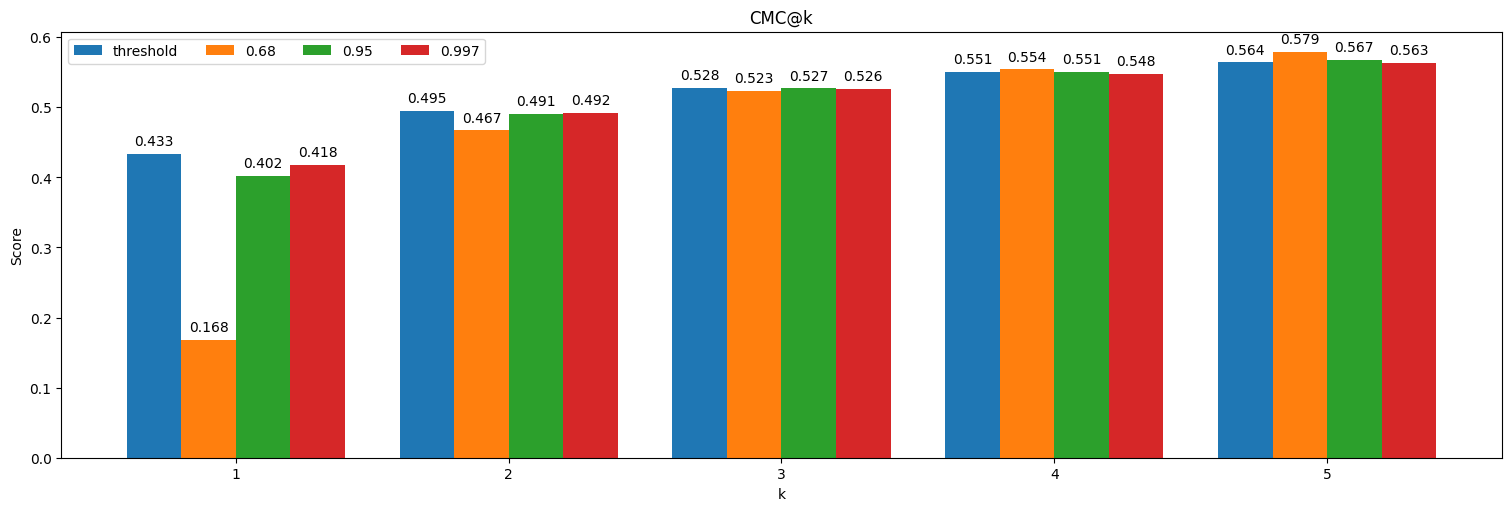

In [40]:
# CMC@k
plot_multiple_bar(
    values=cmc_values,
    x_values=top_k,
    xlabel='k',
    ylabel='Score',
    title='CMC@k'
)

#### mAP@k

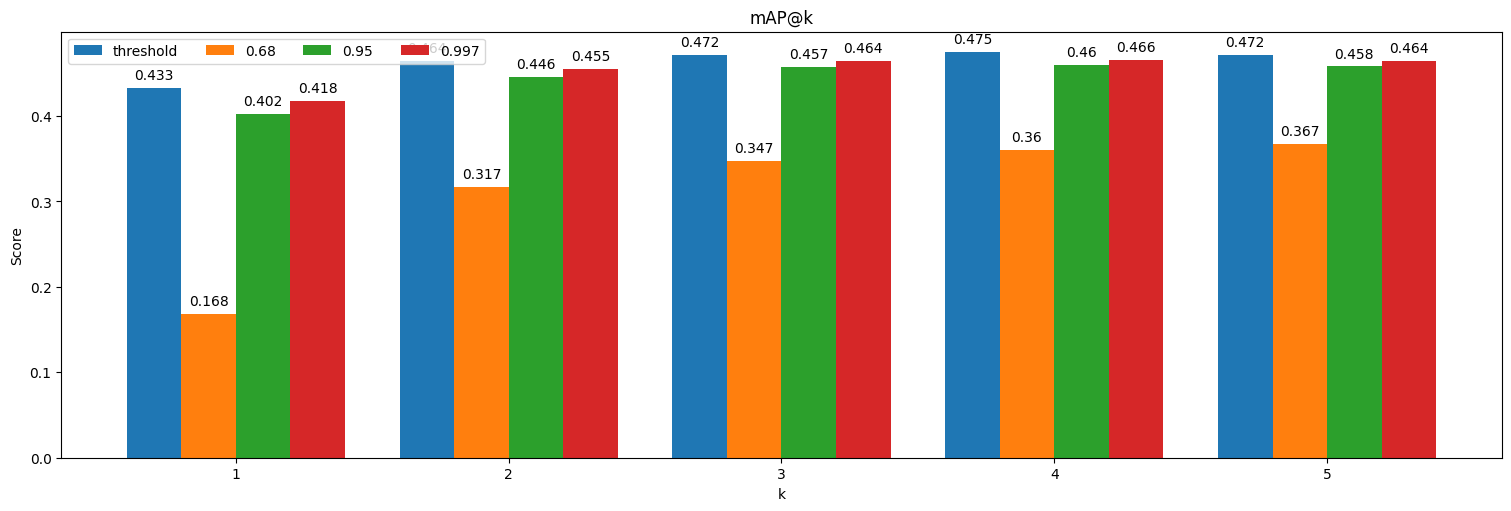

In [41]:
# mAP@k
plot_multiple_bar(
    values=map_values,
    x_values=top_k,
    xlabel='k',
    ylabel='Score',
    title='mAP@k'
)

#### Accuracy

To compare the candidate's choice between 1-knn and n-knn. If n-knn, the lynx_id of the current image will be the one found most often among the neighbours.

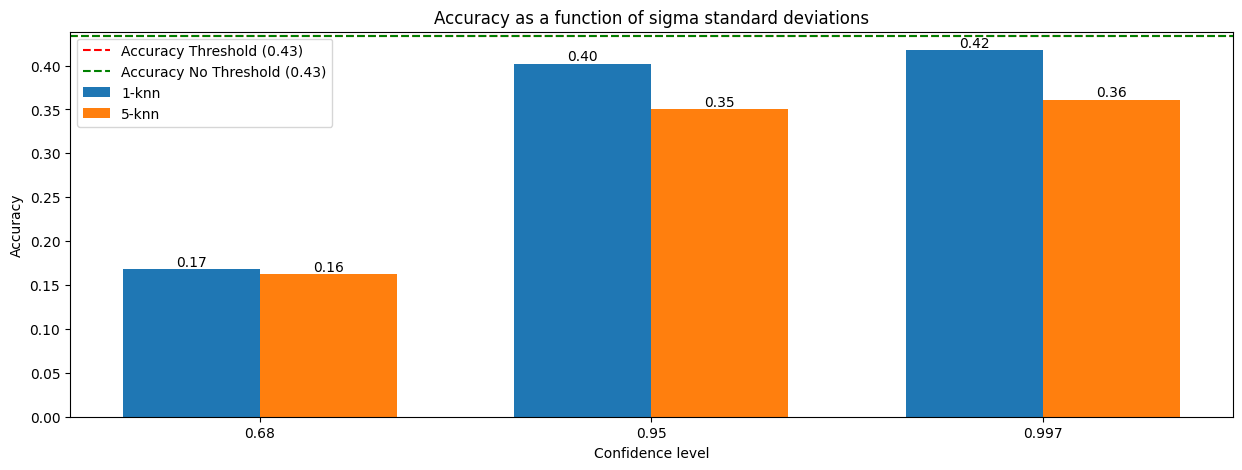

In [42]:
# Accuracy plot
accuracy_list_t = list(zip(*accuracy_list))

plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots()

width = 0.35

# Gaussian
bar1 = ax.bar(range(len(accuracy_list)), accuracy_list_t[0], width=width, label='1-knn')
bar2 = ax.bar([x + width for x in range(len(accuracy_list))], accuracy_list_t[1], width=width, label=f'{n_neighbors}-knn')

# Classic threshold
ax.axhline(y=accuracy_threshold, color='r', linestyle='--', label=f'Accuracy Threshold ({accuracy_threshold:.2f})')
ax.legend()

# No threshold
ax.axhline(y=accuracy_no_threshold, color='g', linestyle='--', label=f'Accuracy No Threshold ({accuracy_no_threshold:.2f})')
ax.legend()

ax.legend()

ax.set_xticks([x + width / 2 for x in range(len(accuracy_list))])
ax.set_xticklabels(confidence_levels)
ax.set_xlabel('Confidence level')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of sigma standard deviations')

ax.legend()

def add_text_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_text_labels(bar1)
add_text_labels(bar2)

plt.show()